# 10章　データの操作

10.1 データの調査

- データの調査で最も単純なのは1次元のデータの統計量をもとめること（データ数, min, max, 平均, 標準偏差など）
- この統計量が理解に寄与しない場合、次に取るべきなのはヒストグラムの作成

In [48]:
# 一次元データの調査

from typing import List, Dict
from collections import Counter
import math
import matplotlib.pyplot as plt

def bucketsize(point: float, bucket_size: float) -> float:
    return bucket_size * math.floor(point / bucket_size)

def make_histogram(points: List[float], bucket_size: float) -> Dict[float, int]:
    return Counter(bucketsize(point, bucket_size) for point in points)

def plot_histogram(points: List[float], bucket_size: float, title: str = ""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width=bucket_size)
    plt.title(title)

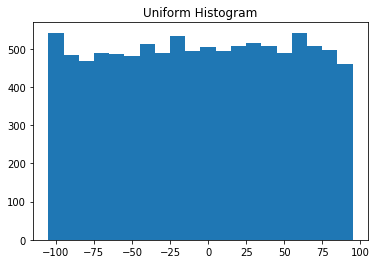

In [49]:
import random
from scratch.probability import inverse_normal_cdf

random.seed(0)

# -100から１００までの一様分布
uniform = [200 * random.random() - 100 for _ in range(10000)]

#　平均0、　標準偏差57の正規分布
# inverse_normal_cdfは正規分布の累積分布関数の逆関数（6.6 正規分布）
normal = [57 * inverse_normal_cdf(random.random())
         for _ in range(10000)]

plot_histogram(uniform, 10, "Uniform Histogram")

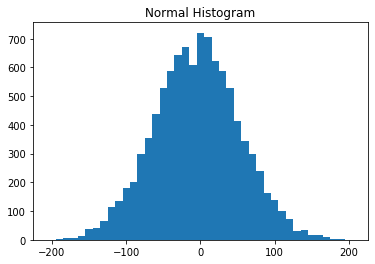

In [50]:
plot_histogram(normal, 10, "Normal Histogram")

# ２つのデータの分布や最大値、最小値がかなり異なることはわかる
# ２つのデータがどのように異なっているかを示すには一次元のデータのプロットでは不十分

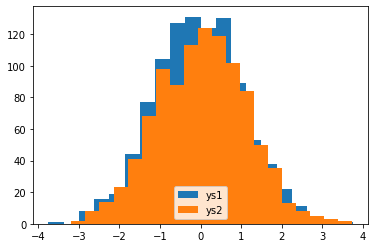

In [51]:
# 二次元データ

def random_normal() -> float: 
    return inverse_normal_cdf(random.random())

xs = [random_normal() for _ in range(1000)]
ys1 = [x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]

plt.hist(ys1, bins=20, label="ys1")
plt.hist(ys2, bins=20, label="ys2")
plt.legend(loc=8)

# ys1とys2をhistogramで可視化した場合は同じようなチャートとして描かれる

Text(0.5, 1.0, 'Very Different Joint Distribution')

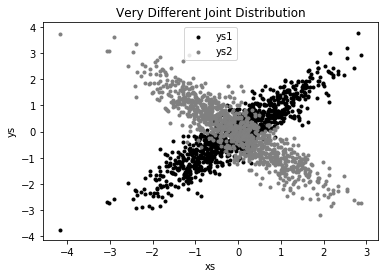

In [52]:
# 実際はxsとの結合分布はys1とys2で大きく異なる

plt.scatter(xs, ys1, marker='.', color='black', label='ys1')
plt.scatter(xs, ys2, marker='.', color='gray', label='ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc=9)
plt.title("Very Different Joint Distribution")

In [53]:
#　相関係数を比較
from scratch.statistics import correlation

print(correlation(xs, ys1))
print(correlation(xs, ys2))

0.9010493686379609
-0.8920981526880033


In [54]:
# scratch/working_with_data.pyより

from typing import List

# Just some random data to show off correlation scatterplots
num_points = 100

def random_row() -> List[float]:
   row = [0.0, 0, 0, 0]
   row[0] = random_normal()
   row[1] = -5 * row[0] + random_normal()
   row[2] = row[0] + row[1] + 5 * random_normal()
   row[3] = 6 if row[2] > -2 else 0
   return row

random.seed(0)
# each row has 4 points, but really we want the columns
corr_rows = [random_row() for _ in range(num_points)]

# 4つの１００次元ベクトルのリスト
corr_data = [list(col) for col in zip(*corr_rows)]


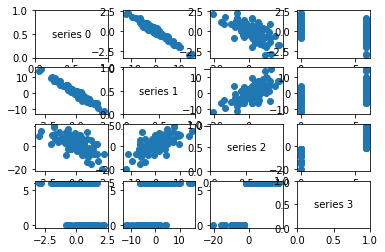

In [55]:
# 多次元データでは、それぞれの次元が他の次元とどのように関連しているか調べる方法に相関行列がある
# 相関行列はi次元とj次元の相関をi行j列の値としたもの
# 次元数がそれほど多く無い場合は散布図行列で可視化する方法もある

from scratch.linear_algebra import Matrix, Vector, make_matrix

def correlation_matrix(data: List[Vector]) -> Matrix:
    def correlation_ij(i: int, j: int) -> float: 
        return correlation(data[i], data[j])
    return make_matrix(len(data), len(data), correlation_ij)

num_vectors = len(corr_data)

# 4x4のsubplotsの枠をつくる
fig, ax = plt.subplots(num_vectors, num_vectors)

for i in range(num_vectors):
    for j in range(num_vectors):
        # 行列指定してscatter plotを描画
        # このケースではif blockをこんな風に改行しないで記述している
        if i != j: ax[i][j].scatter(corr_data[j], corr_data[i])
        else: ax[i][j].annotate("series " + str(i), (0.5, 0.5),
                                xycoords='axes fraction',
                                ha="center", va="center")

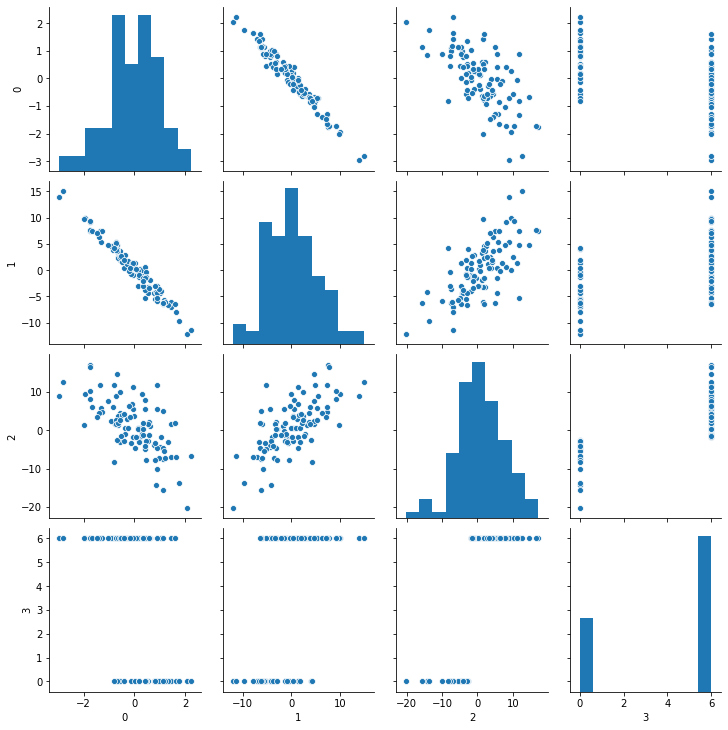

In [56]:
# ちなみにリストをpandasに読み込んでseabornで表示するには
import pandas as pd
import seaborn as sns

df = pd.DataFrame(corr_data)
# corr_dataをdfに読み込んで転置
sns.pairplot(df.T)

In [57]:
# ４つのVector間の相関係数を出力　
# 散布図のsubplotで可視化されたように１と2, 3は負の相関、2と３は正の相関、、の値をとる
correlation_matrix(corr_data)

[[1.0, -0.9811358167114443, -0.6617493801914248, -0.517322308755641],
 [-0.9811358167114445,
  1.0000000000000002,
  0.6818185438510717,
  0.5421152672467888],
 [-0.6617493801914248,
  0.6818185438510717,
  1.0000000000000002,
  0.7461443698023104],
 [-0.517322308755641,
  0.5421152672467889,
  0.7461443698023105,
  0.9999999999999999]]

## 10.2 名前付きタプル（NamedTuple）の利用

- データを表す一般的な方法は辞書だが、辞書はオーバーヘッドがあり、効率が良くなく**理想的な形式とは言えない**
- キーを使った辞書アクセスはエラーが発生しやすい??!!
- 多くの型を持つ辞書には型ヒントを活用できない
- namedtuple(名前つきタプル)クラスがある

namedtupleは
- collection.namedtuple(typename, field_names) のように指定する
- 上のように定義すると、typenameで指定した名前でtupleのsubclassを返す
- field_namesは"sequence of strings" （例えば文字列のリスト）

In [58]:
from collections import namedtuple
import datetime
StockPrice = namedtuple('StockPrice', ['symbol', 'date', 'closing_price'])
price = StockPrice('MSFT', datetime.date(2018, 12, 14), 106.03)

# priceのattributeとして.でアクセスできるようになる模様
assert price.symbol == 'MSFT'
assert price.closing_price == 106.03

print(price)

StockPrice(symbol='MSFT', date=datetime.date(2018, 12, 14), closing_price=106.03)


In [59]:
from typing import NamedTuple

class StockPrice(NamedTuple):
    # 型付き変数の宣言。= で値を代入して初期化できる
    symbol: str
    date: datetime.date
    closing_price: float
        
    def is_high_tech(self) -> bool:
        return self.symbol in ['MSFT', 'GOOG', 'FB', 'AMZN', 'APPL']
    
price = StockPrice('MSFT', datetime.date(2018, 12, 14), 106.03)

assert price.symbol == 'MSFT'
assert price.closing_price == 106.03
assert price.is_high_tech()

## 10.3 データクラス（Dataclass）

- データクラスはNamedTupleを可変にしたようなもの（NamedTupleは通常のタプル同様一度定義すると変更できない）
- データクラスはいくつかのメソッドを自動生成する通常のPythonクラス
- 基本クラスから継承して使うのではなく、デコレータを使う

In [60]:
from dataclasses import dataclass

@dataclass
class StockPrice2:
    symbol: str
    date: datetime.date
    closing_price: float
        
    def is_high_tech(self) -> bool:
        return self.symbol in ['MSFT', 'GOOG', 'FB', 'AMZN', 'APPL']
    
price2 = StockPrice2('MSFT', datetime.date(2018, 12, 14), 106.03)

assert price2.symbol == 'MSFT'
assert price2.closing_price == 106.03
assert price.is_high_tech()

In [61]:
# namedtupleとデータクラスのインスタンスの最大の違いは値を変更できることなのでclosing_priceを変更してみると

price2.closing_price  /= 2
assert price2.closing_price == 53.015

In [62]:
# 普通のクラスなので新しいフィールドを追加できてしまう（下は意図せぬtypoによるフィールドの追加）
price2.cosing_price = 75

## 10.4 データの整理と変換

- データは多くの場合使う前に型変換等の処理を行う必要がある（文字列->浮動小数点などありがち）
- チェックを通らないデータは、取り除く、かけているデータの補足や誤ったデータ修正を試みる、何もしない、の３つの選択肢がある
- 簡易な補足・修正・除外手段をつかうか、外れ値が無いかしらべるか分析者が判断しデータを正しく扱う必要がある


In [63]:
from dateutil.parser import parse
from typing import List

def parse_row(row: List[str]) -> StockPrice: 
    symbol, date, closing_price = row
    return StockPrice(symbol=symbol, date=parse(date).date(), closing_price=float(closing_price))

# NamedTuple生成
stock = parse_row(["MSFT", "2018-12-14", "106.03"])

assert stock.symbol == "MSFT"
assert stock.date == datetime.date(2018, 12, 14)
assert stock.closing_price == 106.03

In [64]:
from typing import Optional
import re

def try_parse_row(row: List[str]) -> Optional[StockPrice]:
    symbol, date_, closing_price_ = row
    
    # symbolの全ての文字が大文字、ではない場合
    if not re.match(r"^[A-Z]+$", symbol):
        return None
    
    try:
        date = parse(date_).date()
    except ValueError:
        return None
    
    try:
        closing_price = float(closing_price_)
    except ValueError:
        return None
    
    return StockPrice(symbol, date, closing_price)

# ValueErrorの場合は Noneを返す
assert try_parse_row(["MSFT0", "2018-12-14", "106.03"]) is None
assert try_parse_row(["MSFT", "2018-12--14", "106.03"]) is None
assert try_parse_row(["MSFT", "2018-12-14", "x"]) is None

assert try_parse_row(["MSFT", "2018-12-14", "106.03"]) == stock

In [65]:
import csv

data: List[StockPrice] = []

with open("comma_delimited_stock_price.csv") as f:
    reader = csv.reader(f)
    for row in reader:
        # csvの値をチェックしつつnamedtupleに変換し、namedtupleのリストを出力する
        maybe_stock = try_parse_row(row)
        if maybe_stock is None:
            print(f"skipping invalide row:  {row}")
        else:
            data.append(maybe_stock)

data

skipping invalide row:  ['MSFT', '6/19/2014', 'n/a']


[StockPrice(symbol='AAPL', date=datetime.date(2014, 6, 20), closing_price=90.91),
 StockPrice(symbol='MSFT', date=datetime.date(2014, 6, 20), closing_price=41.68),
 StockPrice(symbol='FB', date=datetime.date(3014, 6, 20), closing_price=64.5),
 StockPrice(symbol='AAPL', date=datetime.date(2014, 6, 19), closing_price=91.86),
 StockPrice(symbol='FB', date=datetime.date(2014, 6, 19), closing_price=64.34)]

## 10.5 データの操作

In [66]:
# 手順をパターン化し抽象化したツールを作成するのだが
# 例としてまずはAAPLの終値の最高値を調べる手順を構築する

max_aapl_price = max(stock_price.closing_price for stock_price in data if stock_price.symbol == "AAPL")
max_aapl_price

91.86

In [67]:
# 銘柄ごとの最高の終値を見つける

from collections import defaultdict

# 最高値を追跡するための辞書を作成
max_prices: Dict[str, float] = defaultdict(lambda: float('-inf'))
    
# 最高値得るためデータを繰り返して処理して値を更新していく
for sp  in data:
    symbol, closing_price = sp.symbol, sp.closing_price
    if closing_price > max_prices[symbol]:
        max_prices[symbol] = closing_price
        
max_prices

defaultdict(<function __main__.<lambda>()>,
            {'AAPL': 91.86, 'MSFT': 41.68, 'FB': 64.5})

In [68]:
# 1日で最も大きい値の変化、小さい値の変化について着目する
# 昨日の値ときょうの値を関係づけ

from typing import List
from collections import defaultdict

# 銘柄ごとの値
prices: Dict[str, List[StockPrice]] = defaultdict(list)

for sp in data:
    prices[sp.symbol].append(sp)

# 1. 値を日付順に並べ   
#  StockPriceはタプルのリストのためい、sortすると日付でソートされる
pcices = {symbol: sorted(symbol_prices)
         for symbol, symbol_prices in prices.items()}

# 2. zipで昨日の終値-今日の終値の組みを作る
def pct_change(yesterday: StockPrice, today: StockPrice) -> float:
    return today.closing_price / yesterday.closing_price - 1

class DailyChange(NamedTuple):
    symbol: str
    date: datetime.date
    pct_chanage: float

# today.symbolでAttributeError
def day_over_day_changes(prices: List[StockPrice]) -> List[DailyChange]:
    return [DailyChange(symbol=today.symbol,
                       date=today.date,
                       pct_change=pct_change(yesterday, today))
           for yesterday, today in zip(prices, prices[1: ])]

# 3. 昨日の終値-今日の終値の組みに新しい列（change）を追加する
all_changes = [change
              for symbol_prices in prices.values()
              for change in day_over_day_changes(symbol_prices)]

print(all_changes)

# all_changesを使うと各変数の最大値、最小値を求めることが簡単
# symbolごと変化量をまとめたNamedTupleのリストを生成し着目したい要素をドットシンタックスを使って取得
# おそらく通常は辞書で行いたい操作だが、NamedTupleで行なっていることがポイントのパートなのだと思われる
# ただし、このブロックどうしてもエラーが消えない...

max_change = max(all_changes, key=lambda change: change.pct_change)

assert  max_change.symbol == 'AAPL'
assert max_change.date == datetime.date(1007, 8, 6)
assert 0.33 < max_change.pct_change < 0.34

min_change = min(all_changes, key=lambda change: change.pc_change)

TypeError: __new__() got an unexpected keyword argument 'pct_change'

## 10.6 スケールの変更

- 複数の数値的特徴量を持つデータ感の類似度（近さ）を定義する方法として、ユークリッド距離を計算する関数はすでに作っている（４章のドット積、５章の相関のあたり？）
- コサイン類似度はベクトルの大きさを考慮しない場合の尺度、ユークリッド距離の場合ベクトルの大きさ考慮した尺度になる
- 一般的に機械学習で扱うデータは正規化あるいは標準化して使うことが多い
- 10.6では標準化する関数をスクラッチしている（numpy arrayを扱う場合、同様な作業を普通にするかも）
-  scipy, sklearnを使う場合は標準化関数がある

In [69]:
# 身長をインチで表した場合とcmで表した場合で最近傍が異なるケースがある
from scratch.linear_algebra import distance

a_to_b = distance([63, 150], [67, 160]) 
a_to_c = distance([63, 150], [70, 171])
b_to_c = distance([67, 160], [70, 171])
print(a_to_b," " , a_to_c,"", b_to_c)

a_to_b = distance([160, 150], [170.2, 160])
a_to_c = distance([160, 150], [177.8, 171])
b_to_c = distance([170.2, 160], [177.8, 171])
print(a_to_b," " , a_to_c,"", b_to_c)

10.770329614269007   22.135943621178654  11.40175425099138
14.284257068535268   27.52889391167034  13.370115930686627


In [70]:
# 単位の変更で結果が変わってしまうのは紛らわしい
# 各次元の値を直接比較できない場合、それぞれの次元で平均0、標準偏差1となるようにデータのスケールを変更する
# つまり、各次元を「平均値からのの標準偏差分の割合」で表すことで単位をなくす

from typing import Tuple
from scratch.linear_algebra import vector_mean
from scratch.statistics import standard_deviation

def scale(data: List[Vector]) -> Tuple[Vector, Vector]:
    """
    各次元の平均と標準偏差を返す
    """
    dim = len(data[0])
    means = vector_mean(data)
    stdevs = [standard_deviation([vector[i] for vector in data])
             for i in range(dim)]
    return means, stdevs

vectors = [[-3, -1, 1], [-1, 0, 1], [1, 1, 1]]
means, stdevs = scale(vectors)
assert means ==[-1, 0, 1]
assert stdevs ==[2, 1, 0]

In [71]:
def rescale(data: List[Vector]) -> List[Vector]:
    """
    各次元が平均0、標準偏差１となるように入力データのスケールを修正する
    （ただし標準偏差が0の場合は変更しない）// この例の場合[1, 1, 1]は修正しない
    """
    dim = len(data[0])
    means, stdevs = scale(data)
    
    # 各ベクトルのコピーを作る
    rescaled = [v[:] for v in data]
    
    for v in rescaled:
        for i in range(dim):
            if stdevs[i] > 0:
                # 各次元の各値から次元の平均を引き、さらに標準偏差で割った値
                v[i] = (v[i] - means[i] )/stdevs[i]
                
    return rescaled

means, stdevs = scale(rescale(vectors))
assert means == [0, 0, 1]
assert stdevs == [1, 1, 0]


## 10.8 次元削除

- 多次元の特徴空間からより低い次元を作成する。低次元（二次元・三次元）に次元を削除することで可視化することもできる
- PCA（主成分分析）、t-SNE（t-distributed Stochastic Neighbor Embedding）とか良く聞かれると思う
- PCAの場合は分散を最大化できる第一主成分の軸を決め、2番目に分散を最大化できる第一主成分と直行する軸を決め、、のような手順で元の情報を最大に再現できるように次元削除する（といいうのが一般的な解説）
- ここでは、分散を最大化する方向（directional_variance()を最大化する方向）を第一主成分として勾配降下法で求める

In [72]:
from scratch.linear_algebra import subtract

def de_mean(data: List[Vector]) -> List[Vector]:
    """
    すべての次元で平均が0となるように変換
    """
    mean = vector_mean(data)
    return [subtract(vector, mean) for vector in data]

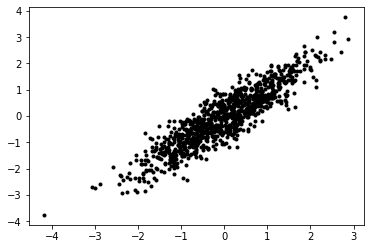

In [74]:
plt.scatter(xs, ys1, marker='.', color='black', label='ys1')

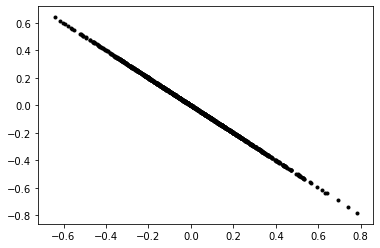

In [86]:
# 例えば下記のように変換するのだと思うが、このケース
# 適切なデータが例示されないためちょっと良くわからない
d = de_mean([xs, ys1])

In [80]:
from scratch.linear_algebra import magnitude

def direction(w: Vector) -> Vector:
    mag = magnitude(w)
    return [w_i / mag for w_i in w   ]

In [81]:
from scratch.linear_algebra import dot

# ベクトルwが与えられた時のデータセットの分散を計算する
def directional_variance(data: List[Vector], w: Vector) -> float:
    """
    wが示す方向に対する, xの分散を求める
    """
    w_dir = direction(w)
    return sum(dot(v, w_dir)**2 for v in data)

In [82]:
# 勾配降下法で分散を最大化する


def directional_variance_gradient(data: List[Vector], w: Vector) -> Vector:
    """
    w方向の分散に対する勾配
    """
    w_dir = direction(w)
    return [sum(2 * dot(v, w_dir)*v[i] for v in data)
           for i in range(len(w))]


In [83]:
import tqdm
from scratch.gradient_descent import gradient_step

# 勾配降下法で分散を最大化する方向を求める
def first_principal_component(data: List[Vector], 
                             n: int = 100, 
                             stip_size: float = 0.1) -> Vector:
    guess = [1.0 for _ in data[0]]
    
    with tqdm.trange(n) as t:
        for _ in t:
            dv = directional_variance(data, guess)
            gradient = directional_variance_gradient(data, guess)
            guess = gradient_step(guess, gradient, step_size)
            t.set_description(f"dv: {dv: .3f}")
            
    return direction(guess)
